Before starting, we need to load the necessary modules in _python_ ...

In [1]:
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Navigate to the cloned repository
%cd EvoNet-CNN-Insight/model_training

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 4675, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 4675 (delta 140), reused 178 (delta 68), pack-reused 4379
Receiving objects: 100% (4675/4675), 5.83 GiB | 30.62 MiB/s, done.
Resolving deltas: 100% (1738/1738), done.
Updating files: 100% (48/48), done.
/content/EvoNet-CNN-Insight/model_training


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model

# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


... and _ImaGene_.

In [3]:
%run -i ../ImaGene.py

In [4]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='../LCT.CEU.vcf')
gene_LCT = file_LCT.read_VCF()
gene_LCT.summary();

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 2200, max 2200, mean 2200.000000, std 0.000000


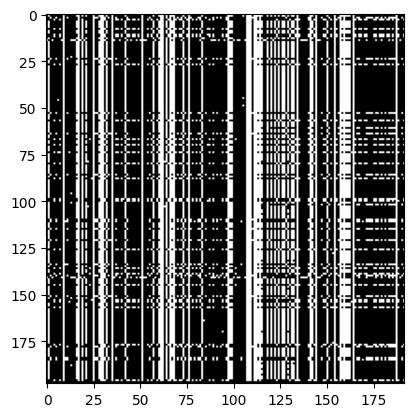

In [5]:
gene_LCT.filter_freq(0.01);
gene_LCT.plot();

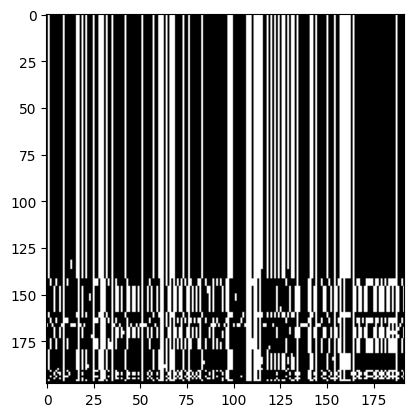

In [6]:
gene_LCT.sort('rows_freq');
gene_LCT.plot();

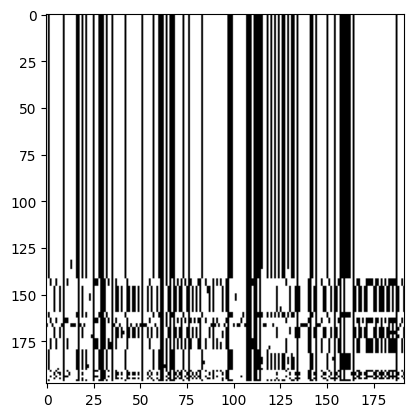

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


In [7]:
gene_LCT.convert(flip=True);
gene_LCT.plot();
gene_LCT.summary();

In [8]:

path = './'

In [9]:
gene_LCT.save(file=path + 'gene_LCT');

In [10]:
gene_LCT = load_imagene(file=path + 'gene_LCT');

### 2. Run and process simulations to be used for training the neural network

_ImaGene_ provides users with an easy interface with _msms_ to run simulations which will be used for training the network.
The script `../generate_dataset.sh` accepts an input file which specifies the parameters of the simulations.
A generic file with all descriptions is `../params.txt`.
If you want to make changes, you need to open the parameter file, change the value of the desired options, save and close it.

We provide an example of this file called `params_binary` which simulates a total of 200,000 loci of 80kbp either under neutral evolution or positive selection with additive effect and an allelic selection coefficient of $1.5$\% targeting a variant in the middle of the region.
Selection starts 800 generations ago (corresponding to 20kya with a generation time of 25 years) with an allele frequency of $0.01$.
We impose a mutation rate is $1.5e-8$ per base per generation and a recombination rate of $1e-8$.
Finally, the simulated population follows a 3-epoch model of bottleneck and expansion as proposed by [Marth et al. 2004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1470693/) for a European population.
We sampled 198 chromosomal copies to match our observed data.

After we specify the directories for _msms_ and the folder where all the simulations will be stored, we can run the following command to perform the simulations. This script will split the simulations into different batches to later perform training with a "simulation-on-the-fly" approach.

In [11]:
# if you wish to generate new training data, do not run otherwise
import subprocess
subprocess.call("bash ../generate_dataset.sh params_Recent_strong.txt".split());

Let's perform the first iteration of training.
To do that, we need to read the first batch of simulations in `[..]/Binary/Simulations1`and store them into an _ImaFile_ object.

In [12]:

path_sim = './'

In [13]:
file_sim = ImaFile(simulations_folder=path_sim + 'RS/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [14]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000);

We can have a look at the data stored in this object.

In [15]:
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 181, max 471, mean 315.316000, std 49.512394


In [16]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 115, max 384, mean 232.855000, std 43.717159


In [17]:
gene_sim.resize((198, 192));
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


In [18]:
gene_sim.convert(flip=True);
gene_sim.summary();

An object of 2000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


Note that in addition to the genomic data, an _ImaGene_ object contains information on the corresponding targets (in this case the selection coefficient, either 0 or 300 in $2N_e$ units with $N_e = 10000$).
As an illustration, let's plot one random image per class.

0


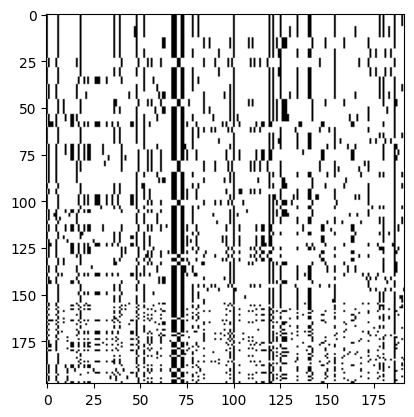

300


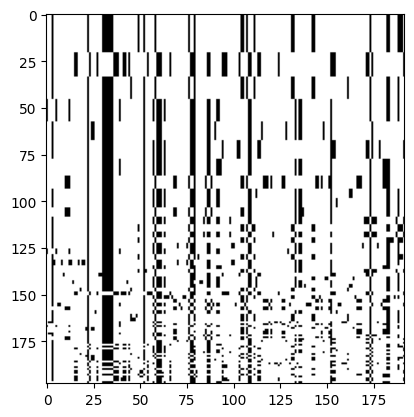

In [19]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [20]:
gene_sim.subset(get_index_random(gene_sim));

In [21]:
gene_sim.targets = to_binary(gene_sim.targets);

In [22]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

In [23]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 190, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 95, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 93, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 22, 64)        0

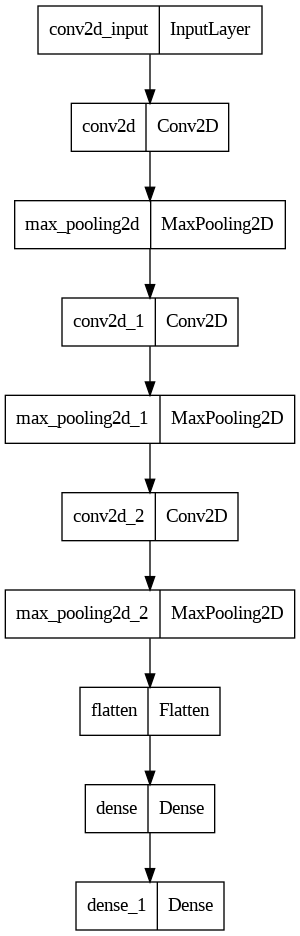

In [24]:
model.summary()
plot_model(model, path + 'net.binary.png')

In [25]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

29/29 [==============================] - 98s 3s/step - loss: 5.5476 - accuracy: 0.5294 - val_loss: 3.9209 - val_accuracy: 0.6800


In [26]:
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

In [27]:
net_LCT.update_scores(score);

In [28]:
i = 2
while i < 10:

    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'RS/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)
    net_LCT.update_scores(score)

    i += 1

2
29/29 [==============================] - 91s 3s/step - loss: 3.0228 - accuracy: 0.7661 - val_loss: 1.9946 - val_accuracy: 0.8800
3
29/29 [==============================] - 92s 3s/step - loss: 1.6285 - accuracy: 0.8906 - val_loss: 1.2251 - val_accuracy: 0.9450
4
29/29 [==============================] - 91s 3s/step - loss: 0.9415 - accuracy: 0.9728 - val_loss: 0.9026 - val_accuracy: 0.8850
5
29/29 [==============================] - 88s 3s/step - loss: 0.6882 - accuracy: 0.9672 - val_loss: 0.6231 - val_accuracy: 0.9550
6
29/29 [==============================] - 95s 3s/step - loss: 0.5413 - accuracy: 0.9700 - val_loss: 1.4394 - val_accuracy: 0.6500
7
29/29 [==============================] - 92s 3s/step - loss: 0.4506 - accuracy: 0.9806 - val_loss: 0.4046 - val_accuracy: 0.9800
8
29/29 [==============================] - 88s 3s/step - loss: 0.3954 - accuracy: 0.9811 - val_loss: 0.3382 - val_accuracy: 0.9950
9
29/29 [==============================] - 88s 3s/step - loss: 0.3509 - accuracy: 0

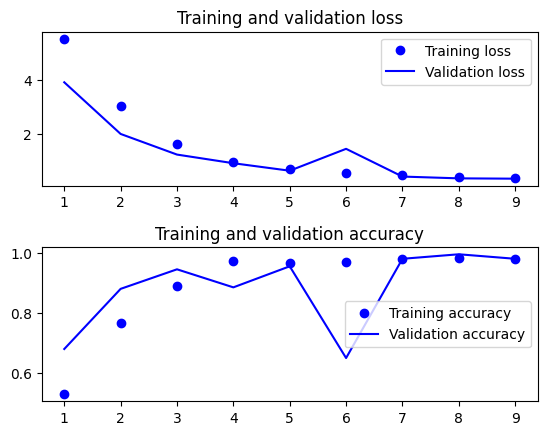

0

In [29]:
net_LCT.plot_train()

In [30]:
model.save(path + 'RS.binary.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
model = load_model(path + 'RS.binary.h5')

Evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [32]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'RS/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test) # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

 report loss and accuracy on the testing set.

In [33]:
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]

[0.31644415855407715, 0.9850000143051147]


Plot the confusion matrix after predicting the responses from the testing data.

63/63 [==============================] - 28s 446ms/step


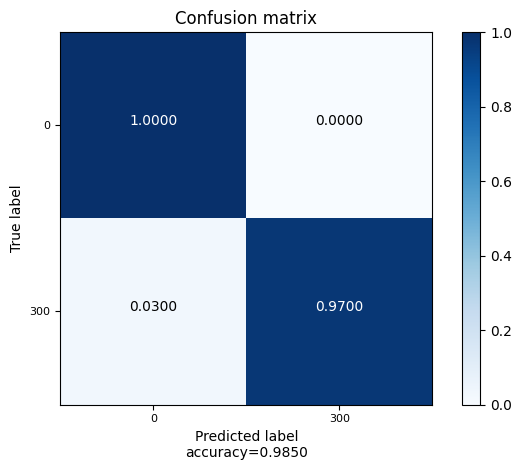

0

In [34]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)

### 4. Deploy the trained network on Genomic regions

In [35]:
print(model.predict(gene_LCT.data, batch_size=None)[0][0])

1/1 [==============================] - 0s 42ms/step
0.9913936
